<a href="https://colab.research.google.com/github/snoop2head/COVID19/blob/master/COVID19_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# mount on drive
# 구글 드라이브와 구글 Colab 연동하기: 밑에 있는 링크를 클릭해서, authentification key를 복사해서 붙여넣으세요.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# ignore warnings 
# R, python3 패키지 다운로드 받을 때 경고를 출력하지 않기 
import warnings
warnings.filterwarnings('ignore')

# CoronaVirus Prediction

In [0]:
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

# bring data from Novel Coronavirus (COVID-19) Cases, provided by Johns Hopkins University CSSE 
# 존스홉킨스대학 CSSE github repository에서 데이터를 가져옵니다.
# https://github.com/CSSEGISandData/COVID-19

# confirmed cases / 확진자 dataframe
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
confirmed = pd.read_csv(url, error_bad_lines=False)

# deceased cases / 사망자 dataframe
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
death = pd.read_csv(url, error_bad_lines=False)

# recovered cases / 완치자 dataframe
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
recover = pd.read_csv(url, error_bad_lines=False)

# fix region names / 지역 이름 변경
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "Unites States")
death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "Unites States")
recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "Unites States")

In [0]:
# Check the dates of the latest JHU CSSE data
# 존스홉킨스 대학의 데이터셋은 매일 업데이트 됩니다. 방금 가져온 데이터의 날짜를 확인합니다. 
confirmed.columns[-1:]

Index(['2/29/20'], dtype='object')

## Get Population

In [0]:
# read population data for each province. China is divided into region whereas other regions of the world is nation 
# 인구 데이터를 불러옵니다. 중국 인구 데이터는 성(省)으로 분류되어 있으며, 나머지 인구데이터는 국가 별로 분류되어 있습니다.
population=pd.read_csv('https://raw.githubusercontent.com/Rank23/COVID19/master/population.csv', sep=',', encoding='latin1') 
population.head()

,Province/State,Country/Region,Population
0,Anhui,China,"62,000,000"
1,Beijing,China,"21,710,000"
2,Chongqing,China,"7,990,000"
3,Fujian,China,"36,894,216"
4,Gansu,China,"25,575,254"


In [0]:
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])
confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,Population
0,Anhui,China,31.8257,117.2264,1,9,15,39,60,70,106,152,200,237,297,340,408,480,530,591,665,733,779,830,860,889,910,934,950,962,973,982,986,987,988,989,989,989,989,989,989,990,990,"62,000,000"
1,Beijing,China,40.1824,116.4142,14,22,36,41,68,80,91,111,114,139,168,191,212,228,253,274,297,315,326,337,342,352,366,372,375,380,381,387,393,395,396,399,399,399,400,400,410,410,411,"21,710,000"
2,Chongqing,China,30.0572,107.8740,6,9,27,57,75,110,132,147,182,211,247,300,337,366,389,411,426,428,468,486,505,518,529,537,544,551,553,555,560,567,572,573,575,576,576,576,576,576,576,"7,990,000"
3,Fujian,China,26.0789,117.9874,1,5,10,18,35,59,80,84,101,120,144,159,179,194,205,215,224,239,250,261,267,272,279,281,285,287,290,292,293,293,293,293,293,293,294,294,296,296,296,"36,894,216"
4,Gansu,China,36.0611,103.8343,0,2,2,4,7,14,19,24,26,29,40,51,55,57,62,62,67,79,83,83,86,87,90,90,90,90,91,91,91,91,91,91,91,91,91,91,91,91,91,"25,575,254"


## Create Time Series + Plots

In [0]:
# merge region
# 인구데이터 dataframe과 확진자 데이터 dataframe을 결합합니다
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:5,:]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,Population,region
0,Anhui,China,31.8257,117.2264,1,9,15,39,60,70,106,152,200,237,297,340,408,480,530,591,665,733,779,830,860,889,910,934,950,962,973,982,986,987,988,989,989,989,989,989,989,990,990,"62,000,000",China_Anhui
1,Beijing,China,40.1824,116.4142,14,22,36,41,68,80,91,111,114,139,168,191,212,228,253,274,297,315,326,337,342,352,366,372,375,380,381,387,393,395,396,399,399,399,400,400,410,410,411,"21,710,000",China_Beijing
2,Chongqing,China,30.0572,107.8740,6,9,27,57,75,110,132,147,182,211,247,300,337,366,389,411,426,428,468,486,505,518,529,537,544,551,553,555,560,567,572,573,575,576,576,576,576,576,576,"7,990,000",China_Chongqing
3,Fujian,China,26.0789,117.9874,1,5,10,18,35,59,80,84,101,120,144,159,179,194,205,215,224,239,250,261,267,272,279,281,285,287,290,292,293,293,293,293,293,293,294,294,296,296,296,"36,894,216",China_Fujian
4,Gansu,China,36.0611,103.8343,0,2,2,4,7,14,19,24,26,29,40,51,55,57,62,62,67,79,83,83,86,87,90,90,90,90,91,91,91,91,91,91,91,91,91,91,91,91,91,"25,575,254",China_Gansu


In [0]:
# Confirmed Korean casses time series dataframe
# 확진자: 한국의 코로나19 확진자 시계열 데이터를 열람합니다
df_korea = confirmed[confirmed['Country/Region'] == 'South Korea']
df_korea

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,Population,region
33,NaN,South Korea,36.0,128.0,1,1,2,2,3,4,4,4,4,11,12,15,15,16,19,23,24,24,25,27,28,28,28,28,28,29,30,31,31,104,204,433,602,833,977,1261,1766,2337,3150,"51,470,000",South Korea_nan


In [0]:
# Recovered Korea casses time series dataframe
# 완치자: 한국의 코로나 19 완치자 시계열 데이터를 열람합니다
df_korea_rec = recover[recover['Country/Region'] == 'South Korea']
df_korea_rec

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,Population,region
33,NaN,South Korea,36.0,128.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,3,3,7,7,7,9,9,10,12,12,16,16,16,18,18,22,22,22,22,27,"51,470,000",South Korea_nan


In [0]:
# create timeseries dataframe for all infected regions
# 감염이 보고된 모든 지역들의 시계열 dataframe을 함수로 제작합니다.
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [0]:
# confirmed case / 확진된 케이스 dataframe
ts=create_ts(confirmed)

# deceased case / 사망한 케이스 dataframe
ts_d=create_ts(death)

# recovered case /  완치된 케이스 dataframe
ts_rec=create_ts(recover)

# check recent 5 days of confirmed cases according to countries
# 가장 최근 5일의 각 국가별로 확진자 수를 봅니다.
ts.tail()

region,Afghanistan_nan,Algeria_nan,Australia_From Diamond Princess,Australia_New South Wales,Australia_Queensland,Australia_South Australia,Australia_Victoria,Australia_Western Australia,Austria_nan,Bahrain_nan,Belarus_nan,Belgium_nan,Brazil_nan,Cambodia_nan,"Canada_ Montreal, QC",Canada_British Columbia,"Canada_London, ON","Canada_Toronto, ON",China_Anhui,China_Beijing,China_Chongqing,China_Fujian,China_Gansu,China_Guangdong,China_Guangxi,China_Guizhou,China_Hainan,China_Hebei,China_Heilongjiang,China_Henan,China_Hubei,China_Hunan,China_Inner Mongolia,China_Jiangsu,China_Jiangxi,China_Jilin,China_Liaoning,China_Ningxia,China_Qinghai,China_Shaanxi,...,North Macedonia_nan,Norway_nan,Oman_nan,Others_Diamond Princess cruise ship,Pakistan_nan,Philippines_nan,Qatar_nan,Romania_nan,Russia_nan,San Marino_nan,Singapore_nan,South Korea_nan,Spain_nan,Sri Lanka_nan,Sweden_nan,Switzerland_nan,Taiwan_Taiwan,Thailand_nan,UK_nan,United Arab Emirates_nan,"Unites States_Boston, MA","Unites States_Chicago, IL","Unites States_Humboldt County, CA","Unites States_Lackland, TX (From Diamond Princess)","Unites States_Los Angeles, CA","Unites States_Madison, WI","Unites States_Omaha, NE (From Diamond Princess)","Unites States_Orange, CA","Unites States_Portland, OR","Unites States_Sacramento County, CA","Unites States_San Antonio, TX","Unites States_San Benito, CA","Unites States_San Diego County, CA","Unites States_Santa Clara, CA","Unites States_Seattle, WA","Unites States_Snohomish County, WA","Unites States_Tempe, AZ","Unites States_Travis, CA (From Diamond Princess)",Unites States_Unassigned Location (From Diamond Princess),Vietnam_nan
2/25/20,1,1,7,4,5,2,4,0,2,23,0,1,0,1,0,7,1,3,989,400,576,294,91,1347,252,146,168,311,480,1271,64786,1016,75,631,934,93,121,71,18,245,...,0,0,2,691,0,3,0,0,2,0,91,977,6,1,1,1,31,37,13,13,1,2,1,0,1,1,0,1,0,1,1,2,2,2,1,0,1,0,36,16
2/26/20,1,1,7,4,5,2,4,0,2,33,0,1,1,1,0,7,1,3,989,400,576,294,91,1347,252,146,168,312,480,1271,65187,1016,75,631,934,93,121,71,18,245,...,1,1,4,705,2,3,0,1,2,0,93,1261,13,1,2,1,32,40,13,13,1,2,1,0,1,1,0,1,0,1,1,2,2,2,1,0,1,0,42,16
2/27/20,1,1,8,4,5,2,4,0,3,33,0,1,1,1,0,7,1,5,989,410,576,296,91,1347,252,146,168,317,480,1272,65596,1017,75,631,934,93,121,72,18,245,...,1,1,4,705,2,3,0,1,2,1,93,1766,15,1,7,8,32,40,15,13,1,2,1,0,1,1,0,1,0,2,1,2,2,2,1,0,1,0,42,16
2/28/20,1,1,8,4,5,2,4,0,3,36,1,1,1,1,1,7,1,5,990,410,576,296,91,1348,252,146,168,318,480,1272,65914,1017,75,631,935,93,121,72,18,245,...,1,6,4,705,2,3,0,3,2,1,93,2337,32,1,7,8,34,41,20,19,1,2,1,0,1,1,0,1,0,2,1,2,2,2,1,0,1,0,44,16
2/29/20,1,1,0,4,9,3,7,2,9,41,1,1,2,1,1,8,1,10,990,411,576,296,91,1349,252,146,168,318,480,1272,66337,1018,75,631,935,93,121,73,18,245,...,1,15,6,705,4,3,1,3,2,1,102,3150,45,1,12,18,39,42,23,21,1,2,1,0,1,1,0,1,1,2,1,2,2,3,6,1,1,0,44,16


In [0]:
# sort regions with number of confirmed casses largest to smallest.
# 각 지역을 가장 많은 확진자부터 적은 순서대로 재배열합니다. 
import matplotlib.pyplot as plt
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)

Text(0.5, 1.0, 'Daily Total Confirmed - Hubei & Korea')

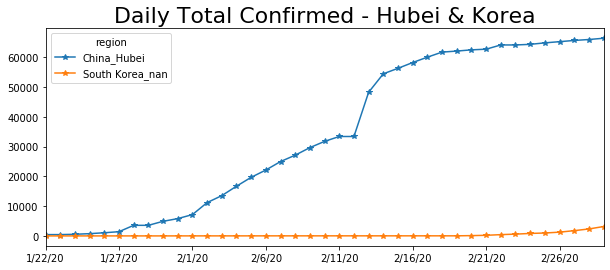

In [0]:
# comparing South Korea's situation with other regions in the world.
# 코로나19 발원지인 후베이성과 한국의 확진자 데이터를 비교합니다.
p.iloc[:,:2].plot(marker='*',figsize=(10,4)).set_title('Daily Total Confirmed - Hubei & Korea',fontdict={'fontsize': 22})

Text(0.5, 1.0, 'Daily Total Confirmed - Major areas')

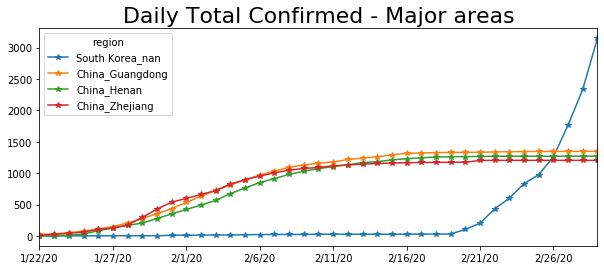

In [0]:
# comparing South Korea to other regions in the world, except for hubei.
# 후베이성을 제외한 나머지 지역들과 한국의 확진자 데이터를 비교합니다
p.iloc[:,1:5].plot(marker='*',figsize=(10,4)).set_title('Daily Total Confirmed - Major areas',fontdict={'fontsize': 22})

Text(0.5, 1.0, 'Daily Total Recoverd - Major areas')

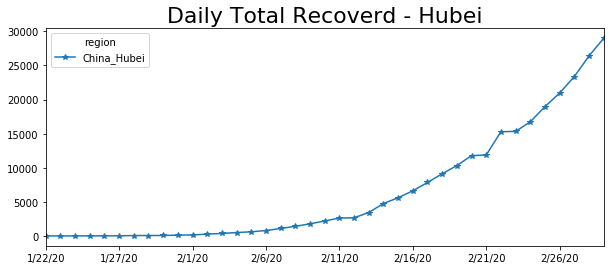

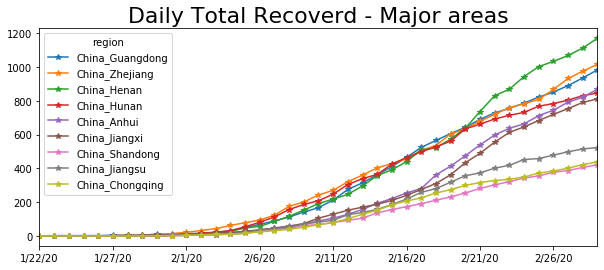

In [0]:
# plot graph of hubei's recovered casses and other major areas
# 후베이성의 완치자 추이와 다른 주요 지역들의 완치자 추이를 봅니다. 
p_r=ts_rec.reindex(ts.mean().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,:1].plot(marker='*',figsize=(10,4)).set_title('Daily Total Recoverd - Hubei',fontdict={'fontsize': 22})
p_r.iloc[:,1:10].plot(marker='*',figsize=(10,4)).set_title('Daily Total Recoverd - Major areas',fontdict={'fontsize': 22})

Text(0.5, 1.0, 'Daily Total Death - Major areas')

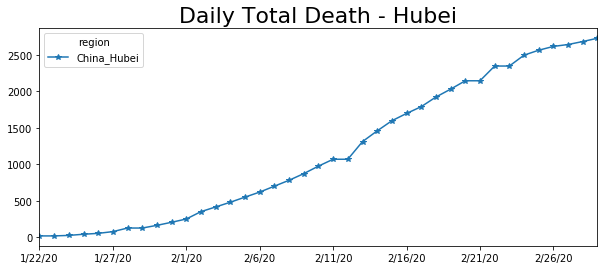

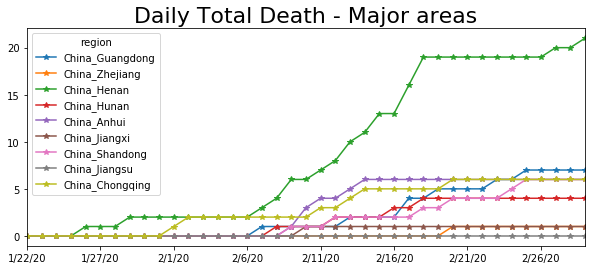

In [0]:
# plot graph of hubei's deceased casses and other major areas
# 후베이성의 사망자 추이와 다른 주요 지역들의 사망자 추이를 봅니다. 
p_d=ts_d.reindex(ts.mean().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,:1].plot(marker='*',figsize=(10,4)).set_title('Daily Total Death - Hubei',fontdict={'fontsize': 22})
p_d.iloc[:,1:10].plot(marker='*',figsize=(10,4)).set_title('Daily Total Death - Major areas',fontdict={'fontsize': 22})

## Kalman Filter With R

In [0]:
# Create data for R script
# R 코드에 입력할 데이터를 CSV파일로 저장할 준비를 합니다
ts_r=ts.reset_index()
ts_r=ts_r.rename(columns = {'index':'date'})
ts_r['date']=pd.to_datetime(ts_r['date'] ,errors ='coerce')

In [0]:
# ENTER YOUR GOOGLE DRIVE PATH TO THE COLABORATORY
# project_path_py에 본인의 프로젝트 폴더를 입력하십시오.
# 예를 들어서, 제 프로젝트 폴더는 COVID19 속의 COVID19이었기 때문에, 이 안에다가 csv 데이터값을 저장하기로 했습니다. 
project_path_py =r'/content/drive/My Drive/COVID19/COVID19/ts_r.csv' 
ts_r.to_csv(project_path_py)

In [0]:
ts_r.tail()

region,date,Afghanistan_nan,Algeria_nan,Australia_From Diamond Princess,Australia_New South Wales,Australia_Queensland,Australia_South Australia,Australia_Victoria,Australia_Western Australia,Austria_nan,Bahrain_nan,Belarus_nan,Belgium_nan,Brazil_nan,Cambodia_nan,"Canada_ Montreal, QC",Canada_British Columbia,"Canada_London, ON","Canada_Toronto, ON",China_Anhui,China_Beijing,China_Chongqing,China_Fujian,China_Gansu,China_Guangdong,China_Guangxi,China_Guizhou,China_Hainan,China_Hebei,China_Heilongjiang,China_Henan,China_Hubei,China_Hunan,China_Inner Mongolia,China_Jiangsu,China_Jiangxi,China_Jilin,China_Liaoning,China_Ningxia,China_Qinghai,...,North Macedonia_nan,Norway_nan,Oman_nan,Others_Diamond Princess cruise ship,Pakistan_nan,Philippines_nan,Qatar_nan,Romania_nan,Russia_nan,San Marino_nan,Singapore_nan,South Korea_nan,Spain_nan,Sri Lanka_nan,Sweden_nan,Switzerland_nan,Taiwan_Taiwan,Thailand_nan,UK_nan,United Arab Emirates_nan,"Unites States_Boston, MA","Unites States_Chicago, IL","Unites States_Humboldt County, CA","Unites States_Lackland, TX (From Diamond Princess)","Unites States_Los Angeles, CA","Unites States_Madison, WI","Unites States_Omaha, NE (From Diamond Princess)","Unites States_Orange, CA","Unites States_Portland, OR","Unites States_Sacramento County, CA","Unites States_San Antonio, TX","Unites States_San Benito, CA","Unites States_San Diego County, CA","Unites States_Santa Clara, CA","Unites States_Seattle, WA","Unites States_Snohomish County, WA","Unites States_Tempe, AZ","Unites States_Travis, CA (From Diamond Princess)",Unites States_Unassigned Location (From Diamond Princess),Vietnam_nan
34,2020-02-25,1,1,7,4,5,2,4,0,2,23,0,1,0,1,0,7,1,3,989,400,576,294,91,1347,252,146,168,311,480,1271,64786,1016,75,631,934,93,121,71,18,...,0,0,2,691,0,3,0,0,2,0,91,977,6,1,1,1,31,37,13,13,1,2,1,0,1,1,0,1,0,1,1,2,2,2,1,0,1,0,36,16
35,2020-02-26,1,1,7,4,5,2,4,0,2,33,0,1,1,1,0,7,1,3,989,400,576,294,91,1347,252,146,168,312,480,1271,65187,1016,75,631,934,93,121,71,18,...,1,1,4,705,2,3,0,1,2,0,93,1261,13,1,2,1,32,40,13,13,1,2,1,0,1,1,0,1,0,1,1,2,2,2,1,0,1,0,42,16
36,2020-02-27,1,1,8,4,5,2,4,0,3,33,0,1,1,1,0,7,1,5,989,410,576,296,91,1347,252,146,168,317,480,1272,65596,1017,75,631,934,93,121,72,18,...,1,1,4,705,2,3,0,1,2,1,93,1766,15,1,7,8,32,40,15,13,1,2,1,0,1,1,0,1,0,2,1,2,2,2,1,0,1,0,42,16
37,2020-02-28,1,1,8,4,5,2,4,0,3,36,1,1,1,1,1,7,1,5,990,410,576,296,91,1348,252,146,168,318,480,1272,65914,1017,75,631,935,93,121,72,18,...,1,6,4,705,2,3,0,3,2,1,93,2337,32,1,7,8,34,41,20,19,1,2,1,0,1,1,0,1,0,2,1,2,2,2,1,0,1,0,44,16
38,2020-02-29,1,1,0,4,9,3,7,2,9,41,1,1,2,1,1,8,1,10,990,411,576,296,91,1349,252,146,168,318,480,1272,66337,1018,75,631,935,93,121,73,18,...,1,15,6,705,4,3,1,3,2,1,102,3150,45,1,12,18,39,42,23,21,1,2,1,0,1,1,0,1,1,2,1,2,2,3,6,1,1,0,44,16


In [0]:
# Starting from here, we code in R. 
# 여기서부터 R로 코딩을 시작합니다. 
import rpy2
%load_ext rpy2.ipython

In [0]:
%%R
install.packages('pracma')
install.packages('reshape')

In [0]:
%%R
# ENTER YOUR GOOGLE DRIVE PATH TO THE COLABORATORY
# 위에서 정의한 project_path_py와 동일한 폴더로 경로를 지정해주시면 됩니다.
project_path_R = '/content/drive/My Drive/COVID19/COVID19/ts_r.csv'

In [0]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv(project_path_R)
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

In [0]:
p=%R pred_all

In [0]:
############ Merge R output due to package problem
t=ts_d
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

t.tail(20)

,date,region,confirmed
2379,2020-02-10,Vietnam_nan,0
2498,2020-02-11,Vietnam_nan,0
2617,2020-02-12,Vietnam_nan,0
2736,2020-02-13,Vietnam_nan,0
2855,2020-02-14,Vietnam_nan,0
2974,2020-02-15,Vietnam_nan,0
3093,2020-02-16,Vietnam_nan,0
3212,2020-02-17,Vietnam_nan,0
3331,2020-02-18,Vietnam_nan,0
3450,2020-02-19,Vietnam_nan,0


## Pre Proccessing Data for ML Model

### Extract Weather Data

In [0]:
# !pip install pyweatherbit

In [0]:

# from weatherbit.api import Api
# import json  
# import pandas as pd  
# from pandas.io.json import json_normalize 
# api_key = "26141d374d8e49d0a2e1f1254428ce8e"
# #api_key ="f206579c74644c4b96a2423cb56a1687"
# #api_key ="81a581ac823849f38427fb5081cb8df8"
# #api_key ="be7aaf4ff7184347aa1ebc2a2db514fe"

# api = Api(api_key)
# api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.
# #api.get_forecast(lat=lat, lon=lon)

###Weather History

In [0]:
# ################## already done since API is limited to 500 call per day

# w=pd.DataFrame(columns=['date','region','min','max'])
# for i in range (61,len(confirmed)):
#   start_date=pd.to_datetime('2020-01-22')
#   for j in range (4,confirmed.shape[1]-2):
#     jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date.strftime('%Y-%m-%d'),end_date=(start_date+ pd.DateOffset(days=1)).strftime('%Y-%m-%d')).json
#     # j=json_normalize(j)
#     # j=j['data']
#     # max_temp=json_normalize(j['data'])['max_temp'].values[0] # max
#     # min_temp=json_normalize(j['data'])['min_temp'].values[0]
#     try:
#       w=w.append({'date':confirmed.columns[j],'region':confirmed.iloc[i,confirmed.shape[1]-1] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
#     except Exception:
#       w=w.append({'date':confirmed.columns[j],'region':confirmed.iloc[i,confirmed.shape[1]-1] ,'min':None,'max':None}, ignore_index=True)
#     start_date=start_date+ pd.DateOffset(days=1)

In [0]:
# ################## Update Recent Day Weather

# w_update=pd.DataFrame(columns=['date','region','min','max'])
# for i in range (28,len(confirmed)):
#   start_date=pd.to_datetime('2020-02-17')
#   for j in range (confirmed.shape[1]-4,confirmed.shape[1]-2):
#     jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date.strftime('%Y-%m-%d'),end_date=(start_date+ pd.DateOffset(days=1)).strftime('%Y-%m-%d')).json
#     try:
#       w_update=w_update.append({'date':confirmed.columns[j],'region':confirmed.iloc[i,confirmed.shape[1]-1] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
#     except Exception:
#       w_update=w_update.append({'date':confirmed.columns[j],'region':confirmed.iloc[i,confirmed.shape[1]-1] ,'min':None,'max':None}, ignore_index=True)
#     start_date=start_date+ pd.DateOffset(days=1)

In [0]:
# w_update.to_csv(r'w_update.csv')

### Extract Weather Forecast Data

In [0]:
# ################## Forecast Weather With API - Already Done
# #forecast = api.get_forecast(lat=lat, lon=lon)

# w_forecast=pd.DataFrame(columns=['datetime','min_temp','max_temp','region'])
# for i in range (0,len(confirmed)):
#     jas=api.get_forecast(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3]).json
#     jas=json_normalize(jas['data'])[['datetime','min_temp','max_temp']]
#     try:
#       w_forecast_temp=jas
#       w_forecast_temp['region']=confirmed.iloc[i,confirmed.shape[1]-1]
#     except Exception:
#       w_forecast_temp=pd.DataFrame(columns=['datetime','min_temp','max_temp','region'])
#     w_forecast=w_forecast.append(w_forecast_temp)
# w_forecast=w_forecast[['datetime','region','min_temp','max_temp']]
# w_forecast.columns = ['date', 'region', 'min', 'max']
# w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%Y-%m-%d')

In [0]:
# preceding days' weather data
w=pd.read_csv('https://raw.githubusercontent.com/Rank23/COVID19/master/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')
#w['date']=pd.to_datetime(w['date'],errors ='coerce')

# weather forecast data
w_forecast=pd.read_csv('https://raw.githubusercontent.com/Rank23/COVID19/master/w.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Build Train Set Data Structure

In [0]:
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
# 예측을 위해서 하루를 dataframe에 추가합니다.
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [0]:
t.tail(7)

,date,region,confirmed
4753,2020-02-24,Vietnam_nan,16
4754,2020-02-25,Vietnam_nan,16
4755,2020-02-26,Vietnam_nan,16
4756,2020-02-27,Vietnam_nan,16
4757,2020-02-28,Vietnam_nan,16
4758,2020-02-29,Vietnam_nan,16
4759,2020-03-01,Vietnam_nan,0


In [0]:
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is t.iloc[i-2,1]):
    t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
    t.iloc[i,6]=(t.iloc[i-1,2]/t.iloc[i-2,2]-1)*100
    t.iloc[i,9]=t.iloc[i-1,2]
  if(t.iloc[i,1] is t.iloc[i-4,1]):
    t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
    t.iloc[i,7]=(t.iloc[i-1,2]/t.iloc[i-4,2]-1)*100
  if(t.iloc[i,1] is t.iloc[i-8,1]):
    t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
    t.iloc[i,8]=(t.iloc[i-1,2]/t.iloc[i-8,2]-1)*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)
t['kalman_prediction']=round(t['kalman_prediction'])
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(1)
train['population']=train['population'].astype('int32')
train['infected_rate'] =train['last_day']/train['population']*10000
train=train.merge(w,how='left',on=['date','region'])
train=train.sort_values(['region', 'date'])
### fill missing weather 
# for i in range(0,len(train)):
#   if(np.isnan(train.iloc[i,13])):
#     if(train.iloc[i,1] is train.iloc[i-1,1]):
#       train.iloc[i,13]=train.iloc[i-1,13]
#       train.iloc[i,14]=train.iloc[i-1,14]

## Kalman 1 day Prediction with Evaluation

In [0]:
# Select region
# 한국을 지역으로서 선택합니다.
region='South Korea_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0

In [0]:
for i in range(1,len(t)):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    ex=np.array(t.iloc[i-len(ts):i,10])
    # print(ex)
    pred=np.array(t.iloc[i-len(ts):i,2])
    # print(pred)
    evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
    # print(evaluation)


In [0]:
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
p.tail(10)

,date,region,confirmed,kalman_prediction
3630,2020-02-21,South Korea_nan,204,77.0
3631,2020-02-22,South Korea_nan,433,166.0
3632,2020-02-23,South Korea_nan,602,361.0
3633,2020-02-24,South Korea_nan,833,579.0
3634,2020-02-25,South Korea_nan,977,841.0
3635,2020-02-26,South Korea_nan,1261,1067.0
3636,2020-02-27,South Korea_nan,1766,1349.0
3637,2020-02-28,South Korea_nan,2337,1797.0
3638,2020-02-29,South Korea_nan,3150,2383.0
3639,2020-03-01,South Korea_nan,0,3188.0


In [0]:
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.tail(10)

,region,confirmed,kalman_prediction
date,,,
2020-02-21,South Korea_nan,204.0,77.0
2020-02-22,South Korea_nan,433.0,166.0
2020-02-23,South Korea_nan,602.0,361.0
2020-02-24,South Korea_nan,833.0,579.0
2020-02-25,South Korea_nan,977.0,841.0
2020-02-26,South Korea_nan,1261.0,1067.0
2020-02-27,South Korea_nan,1766.0,1349.0
2020-02-28,South Korea_nan,2337.0,1797.0
2020-02-29,South Korea_nan,3150.0,2383.0


             region            mse        rmse    mae
90  South Korea_nan  294578.102564  542.750498  160.0


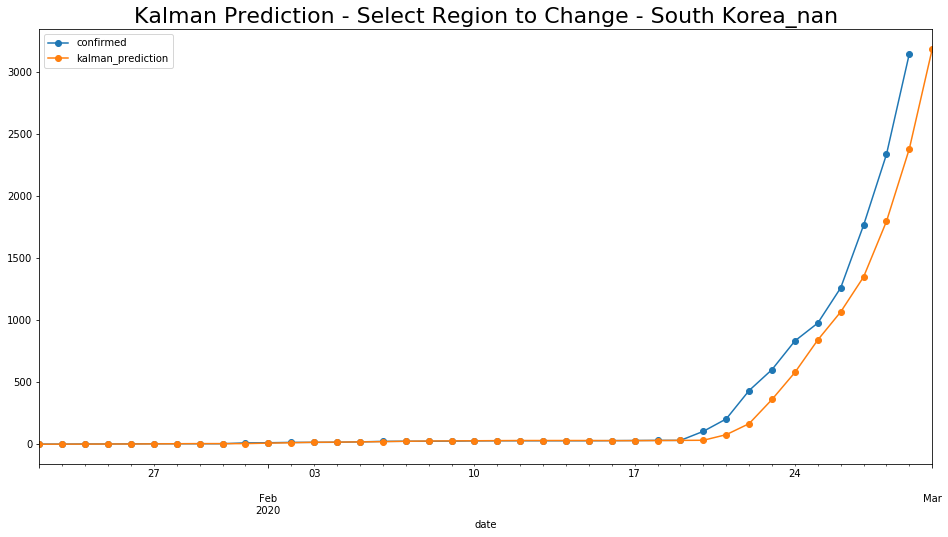

In [0]:
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]),fontdict={'fontsize': 22})
print(evaluation[evaluation['region']==p.iloc[0,0]])

            region          mse       rmse        mae
41  China_Shanghai  2999.615385  54.768745  15.307692


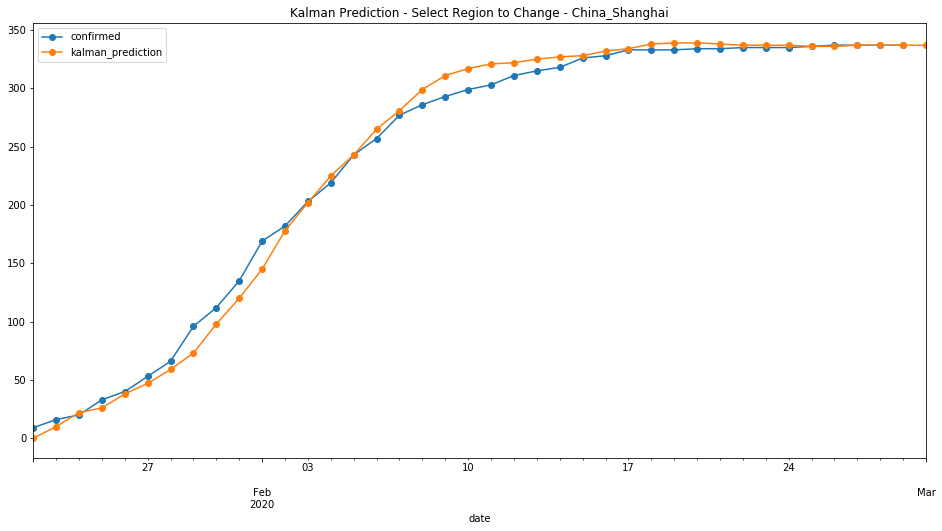

In [0]:
# Select region
region='China_Shanghai'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    ex=np.array(t.iloc[i-len(ts):i,10])
    pred=np.array(t.iloc[i-len(ts):i,2])
    evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))
print(evaluation[evaluation['region']==p.iloc[0,0]])

       region           mse        rmse        mae
65  Italy_nan  40843.051282  202.096638  60.435897


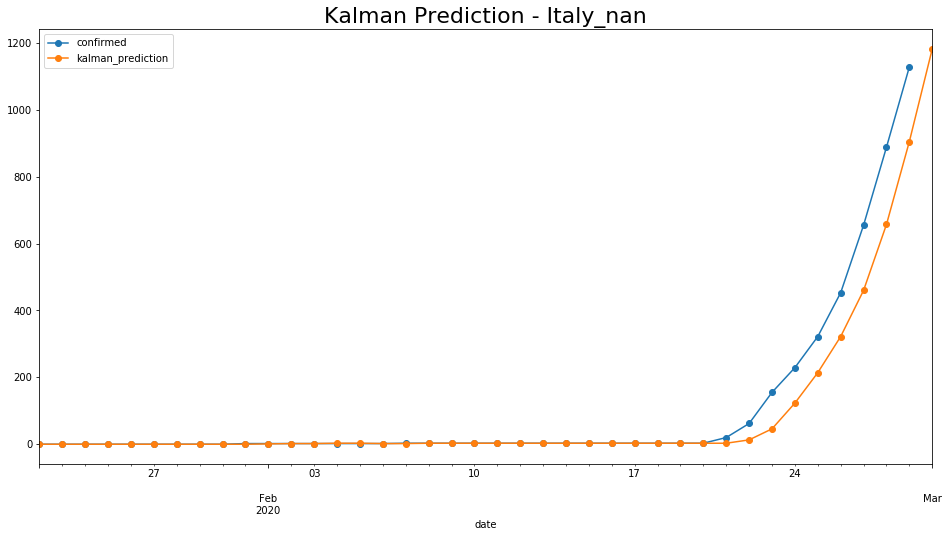

In [0]:
# Select region
region='Italy_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    ex=np.array(t.iloc[i-len(ts):i,10])
    pred=np.array(t.iloc[i-len(ts):i,2])
    evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - {}'.format(p.iloc[0,0]),fontdict={'fontsize': 22})
print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [0]:
!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='8G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp5ofdn3t2
  JVM stdout: /tmp/tmp5ofdn3t2/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp5ofdn3t2/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,24 days
H2O cluster name:,H2O_from_python_unknownUser_8rgi20
H2O cluster total nodes:,1
H2O cluster free memory:,8 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


In [0]:
# today's date
# 오늘의 날짜를 출력합니다
from datetime import date, datetime, timedelta
today_int = date.today()
today_str = str(today_int)
today_str

'2020-03-01'

In [0]:
# recent days for boosting below
# 데이터에 가중치를 둘 최근의 날짜를 설정합니다.
d = datetime.today() - timedelta(days=5)
boosting_date = str(d.date())
boosting_date

'2020-02-25'

In [0]:
# available datasets to train
# 훈련을 시킬 데이터셋을 불러옵니다
d2 = datetime.today() - timedelta(days=1)
training_d = str(d2.date())
training_d

'2020-02-29'

In [0]:
train.tail()

,date,region,confirmed,1_day_change,3_day_change,7_day_change,1_day_change_rate,3_day_change_rate,7_day_change_rate,last_day,kalman_prediction,population,infected_rate,min,max
5093,2020-02-26,Vietnam_nan,16,0,0,0,0.0,0.0,0.0,16,16.0,95540000,0.001675,19.0,27.0
5094,2020-02-27,Vietnam_nan,16,0,0,0,0.0,0.0,0.0,16,16.0,95540000,0.001675,NaN,NaN
5095,2020-02-28,Vietnam_nan,16,0,0,0,0.0,0.0,0.0,16,16.0,95540000,0.001675,NaN,NaN
5096,2020-02-29,Vietnam_nan,16,0,0,0,0.0,0.0,0.0,16,16.0,95540000,0.001675,NaN,NaN
5097,2020-03-01,Vietnam_nan,0,0,0,0,0.0,0.0,0.0,16,16.0,95540000,0.001675,NaN,NaN


In [0]:
train=train.fillna(0) 
train_df=train[train['date']<training_d]

# some bootstrap to give more weight for recent days
# 최근의 확진자 데이터에 가중을 둬서 훈련을 시킵니다.
boots=train_df[train_df['date']>=boosting_date] 
train_df=train_df.append([boots[boots['date']>=boosting_date]]*1000,ignore_index=True)
train_df_hubei=train_df[train_df['region']=='China_Hubei']
test=train[train['date']>=training_d]
test=test[test['date']<training_d]
test

,date,region,confirmed,1_day_change,3_day_change,7_day_change,1_day_change_rate,3_day_change_rate,7_day_change_rate,last_day,kalman_prediction,population,infected_rate,min,max


In [0]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            # '1_day_change_rate', 
            #'3_day_change_rate',
             '7_day_change_rate', 
            'last_day', 'kalman_prediction','infected_rate', 'min', 'max'
          ]

In [0]:
x=train_df[x_col]
x.tail()

,1_day_change,3_day_change,7_day_change,7_day_change_rate,last_day,kalman_prediction,infected_rate,min,max
662855,0,0,0,0.0,16,16.0,0.001675,15.0,21.6
662856,0,0,0,0.0,16,16.0,0.001675,18.0,27.0
662857,0,0,0,0.0,16,16.0,0.001675,19.0,27.0
662858,0,0,0,0.0,16,16.0,0.001675,0.0,0.0
662859,0,0,0,0.0,16,16.0,0.001675,0.0,0.0


In [0]:
y=train_df['confirmed']
y.tail()

662855    16
662856    16
662857    16
662858    16
662859    16
Name: confirmed, dtype: int64

In [0]:
reg = LinearRegression().fit(x,y)

In [0]:
# pred2=reg.predict(test[x_col])
pred2=reg.predict(x)
pred2=pd.DataFrame(pred2)
pred2=round(pred2)
pred2

,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
662855,17.0
662856,17.0
662857,17.0
662858,17.0


In [0]:
len(pred2[0])
len(test['confirmed'].values)
# pred2['date']=test['date'].values
# pred2['region']=test['region'].values
# #pred2.iloc[:55]

0

In [0]:
train_h20 = h2o.H2OFrame(train_df)
train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
training_columns = ['region','1_day_change', '3_day_change', '7_day_change', '1_day_change_rate', '3_day_change_rate',
                    '7_day_change_rate', 'last_day', 'kalman_prediction','infected_rate', 'min', 'max'
                   ]                 
# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)
model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF

,variable,relative_importance,scaled_importance,percentage
0,kalman_prediction,5.826823e+12,1.000000,0.326218
1,last_day,4.254977e+12,0.730240,0.238217
2,infected_rate,3.456780e+12,0.593253,0.193530
3,1_day_change_rate,1.766209e+12,0.303117,0.098882
4,3_day_change_rate,1.097823e+12,0.188408,0.061462
5,7_day_change,5.275800e+11,0.090543,0.029537
6,7_day_change_rate,4.531808e+11,0.077775,0.025372
7,3_day_change,2.834065e+11,0.048638,0.015867
8,1_day_change,1.148909e+11,0.019718,0.006432
9,min,4.194560e+10,0.007199,0.002348


In [0]:
# # Model performance
# performance = model_hubei.model_performance(test_data=test_h20_hubei)
# # Model Create Predictions
# pred=model_hubei.predict(test_h20_hubei);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
# pred['confirmed']=test_hubei['confirmed'].values
# pred['date']=test_hubei['date'].values
# pred['region']=test_hubei['region'].values

# pred2=model.predict(test_h20);pred2=pred2.as_data_frame(); pred2=round(pred2)
# pred2['confirmed']=test['confirmed'].values
# pred2['date']=test['date'].values
# pred2['region']=test['region'].values
# pred=pred.append(pred2)

## Correlation Matrix And Temperature

Correlation Matrix


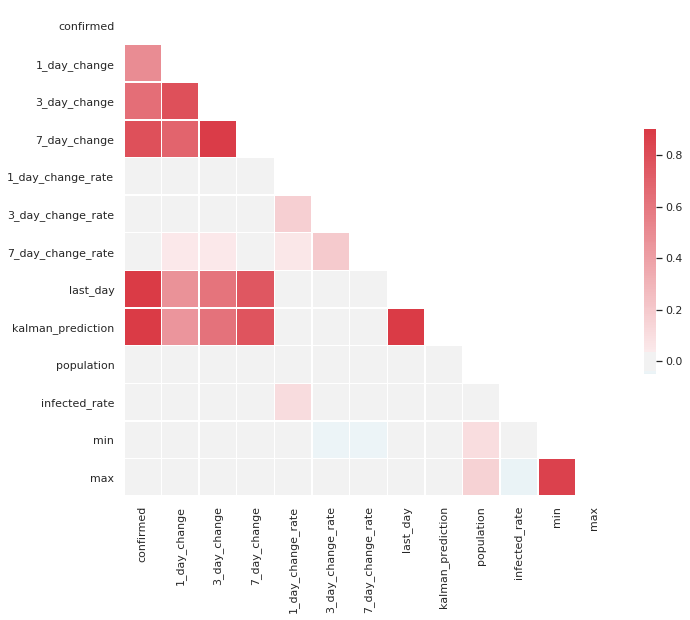

In [0]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [0]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.497626
3_day_change         0.646740
7_day_change         0.792051
1_day_change_rate   -0.002134
3_day_change_rate    0.001814
7_day_change_rate    0.011890
last_day             0.966554
kalman_prediction    0.968590
population           0.012703
infected_rate       -0.004973
min                  0.016528
max                  0.030958
Name: confirmed, dtype: float64


Text(0.5, 1.0, 'Daily Min/Max Temperature - Hubei')

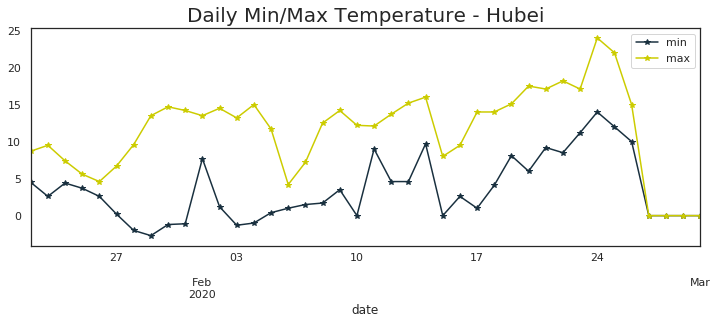

In [0]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
p=p[p['region']=='China_Hubei']
p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - Hubei',fontdict={'fontsize': 20})

In [0]:
# avg_temp=train[['region','confirmed','min','max']]  # from 17-02-20
# avg_temp=avg_temp.groupby(by='region').mean()
# avg_temp=avg_temp.sort_values('confirmed',ascending=False)
# print( 'Most infected Areas Avg Temperature')
# print(avg_temp.iloc[:10,1:])

##Kalman X Days Ahead Prediction

In [0]:
%%R
install.packages('reshape')

In [0]:
%%R
require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/content/drive/My Drive/COVID19/COVID19/ts_r.csv")
all$X1<-NULL
for (i in 1:30) { # Set i days prediction
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

In [0]:
all_new=%R all_new

In [0]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction South Korea_nan')

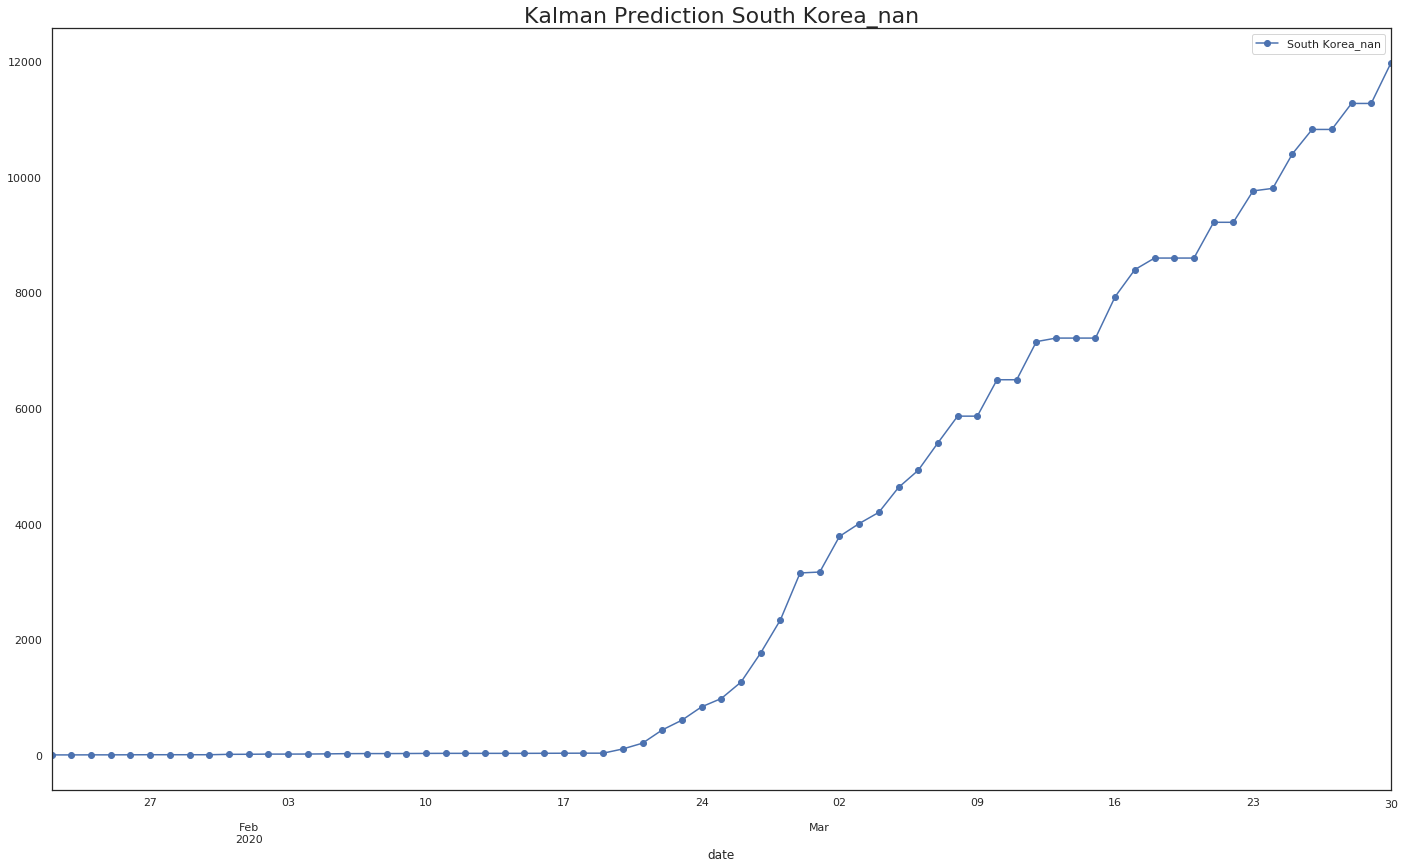

In [0]:
# 한국의 향후 30일 확진자 추이를 그래프로 표현합니다.
region = ['date', "South Korea_nan"]
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction {}'.format(region[1]), fontdict={'fontsize': 22})

In [0]:
prediction_one_month = p_kalman.tail(30)
prediction_two_weeks = prediction_one_month.head(15)
prediction_two_weeks

,South Korea_nan
date,
2020-03-01,3166.0
2020-03-02,3783.0
2020-03-03,4005.0
2020-03-04,4199.0
2020-03-05,4630.0
2020-03-06,4927.0
2020-03-07,5402.0
2020-03-08,5864.0
2020-03-09,5864.0


Text(0.5, 1.0, 'Kalman Prediction - Select Region to Change - China_Hubei')

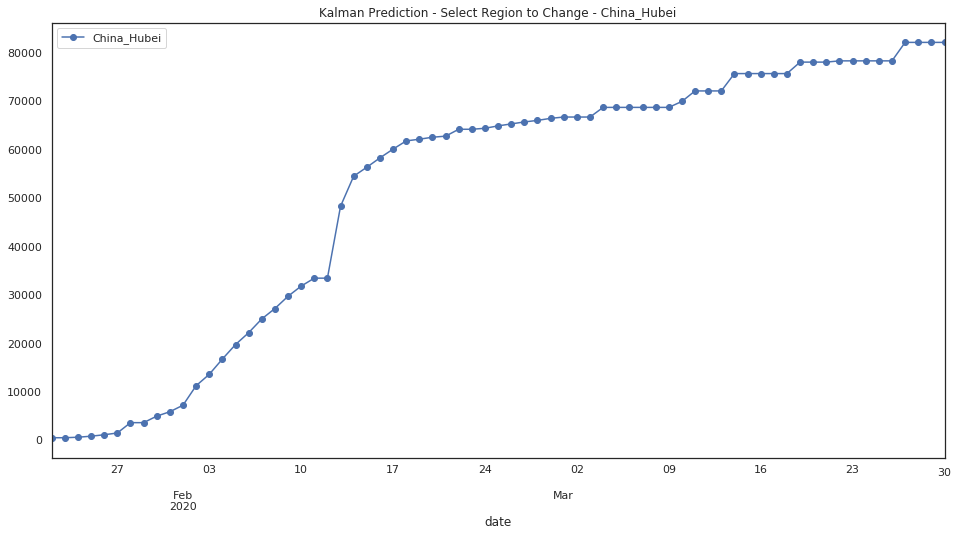

In [0]:
p_kalman2=all_new[['date','China_Hubei']]
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p_kalman2.columns[0]))

In [0]:
# t.to_csv(r't.csv')

## Iterative Regression

In [0]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
  if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
    t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
  if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
    t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
    t_iter.iloc[i,6]=(t_iter.iloc[i-1,2]/t_iter.iloc[i-2,2]-1)*100
    t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
  if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
    t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
    t_iter.iloc[i,7]=(t_iter.iloc[i-1,2]/t_iter.iloc[i-4,2]-1)*100
  if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
    t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
    t_iter.iloc[i,8]=(t_iter.iloc[i-1,2]/t_iter.iloc[i-8,2]-1)*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])
test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(1)
test_iter['population']=test_iter['population'].astype('int32')
test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])
test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
  if(np.isnan(test_iter.iloc[i,13])):
    if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
      test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
      test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


In [0]:
test_iter=test_iter.fillna(0) 
# test_iter[test_iter.isnull().any(axis=1)]

In [0]:
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values
for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
      if(pred.iloc[i,0]<pred.iloc[i-1,1]):
        pred.iloc[i,0]=pred.iloc[i-1,1]
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

ValueError: ignored

In [0]:
region = ['date', "South Korea_nan", "Japan_nan", "Italy_nan"]
        
p=pred[region]
p.plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

In [0]:
p2=pred['China_Hubei']
p2.plot(marker='o',figsize=(16,8),title ='Hubei Prediction')

In [0]:
p=pd.DataFrame(p)


## Prediction Heatmap

In [0]:
pip install gmplot

In [0]:
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [0]:
heatmap=confirmed[['region','Lat','Long']]
p_m=pred.T
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')

In [0]:
heatmap_m.columns.values[61] #9/30/61

In [0]:
heatmap=pd.DataFrame()
for i in range(0,len(heatmap_m)):
  if heatmap_m.iloc[i,61].astype(int)==0: # heatmap_m.iloc[i,9] columns is the date we want to check
    continue
  #heatmap=heatmap.append(pd.concat([heatmap_m.iloc[i:(i+1),:]]*abs(heatmap_m.iloc[i,30].astype(int)), ignore_index=True,sort=False))
  heatmap=heatmap.append(pd.concat([heatmap_m.iloc[i:(i+1),1:3]]*abs(heatmap_m.iloc[i,30].astype(int)), ignore_index=True,sort=False))


In [0]:
latitudes = heatmap['Lat']
longitudes = heatmap['Long']
# Creating the location we would like to initialize the focus on. 
# Parameters: Lattitude, Longitude, Zoom
gmap = gmplot.GoogleMapPlotter(30.97564, 112.2707, 5)
gmap.heatmap(latitudes, longitudes)
# Generate the heatmap into an HTML file
gmap.draw("Heatmap4-2020-02-18.html")